# Example notebook showing how to interactively perform a spectral analysis

## Define target region

In [1]:
from gammapy.extern.regions import CircleSkyRegion
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import Target
import astropy.units as u
import numpy as np

center = SkyCoord(ra=83.63, dec=22.01, unit='deg', frame='icrs')
radius = Angle('0.3 deg')
on_region = CircleSkyRegion(center = center, radius = radius)

target = Target(on_region = on_region, name='Crab', tag='crab_test')
print(target)

Target: Crab
Tag: crab_test
On region: CircleSkyRegion
Center:<SkyCoord (ICRS): (ra, dec) in deg
    (83.63, 22.01)>
Radius:0.3 deg



## Make exclusion mask

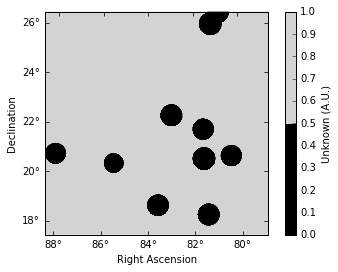

In [2]:
%matplotlib inline
from gammapy.image import ExclusionMask
from astropy.wcs import WCS
import matplotlib.pyplot as plt


mask = ExclusionMask.empty(nxpix = 901, nypix =901, binsz=0.01, coordsys='CEL',
                           xref=on_region.center.ra.value, yref=on_region.center.dec.value, 
                           dtype=int, fill=1)

mask.fill_random_circles(n=10, min_rad=50)

mask.plot()


## Load Data

In [3]:
from gammapy.data import DataStore, ObservationList
datastore = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')
observations = ObservationList(datastore.obs(obs_id) for obs_id in [23523, 23559])

## Estimate background

In [4]:
from gammapy.background import reflected_regions_background_estimate


bkg = [reflected_regions_background_estimate(target.on_region,
                                             obs.pointing_radec,
                                             mask, obs.events) for obs in observations]


## Quick look debug plots

*** Observation Wise summary ***
*** Observation summary report ***
Observation Id: 23523
Livetime: 0.439 h
On events: 235
Off events: 110
Alpha: 0.333
Bkg events in On region: 36.67
Excess: 198.33
Excess / Background: 5.41
Gamma rate: 8.91 1 / min
Bkg rate: 1.39 1 / min
Sigma: 16.82

*** Observation summary report ***
Observation Id: 23559
Livetime: 0.438 h
On events: 134
Off events: 212
Alpha: 0.077
Bkg events in On region: 16.31
Excess: 117.69
Excess / Background: 7.22
Gamma rate: 5.09 1 / min
Bkg rate: 0.62 1 / min
Sigma: 16.64




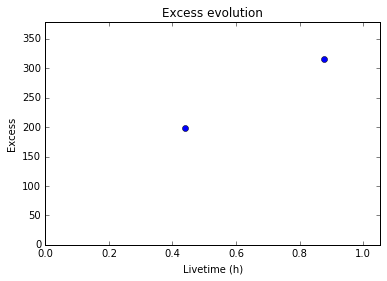

In [5]:
from gammapy.data import ObservationStats, ObservationSummary
stats = list()
for _obs, _bkg in zip(observations, bkg):
    stats.append(ObservationStats.from_target(_obs, target, _bkg))

obs_summary=ObservationSummary(stats)
print(obs_summary.obs_wise_summary())
obs_summary.plot_excess_vs_livetime()

## Extract spectrum

In [6]:
from gammapy.spectrum import SpectrumExtraction
extraction = SpectrumExtraction(target = target,
                                obs = observations,
                                background = bkg)
extraction.run(outdir='crab_analysis')

/home/kingj/Software/miniconda3/envs/headsherpa/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


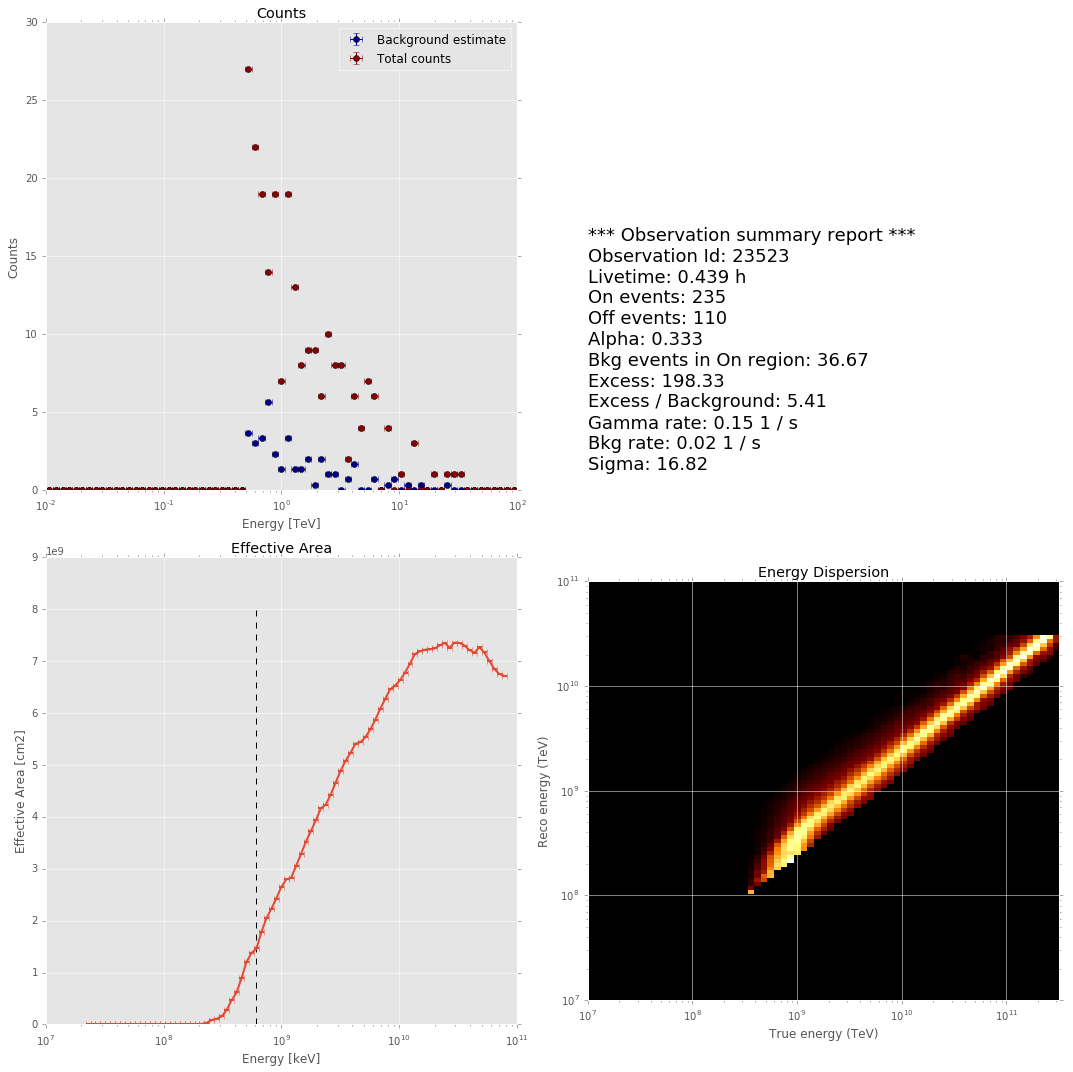

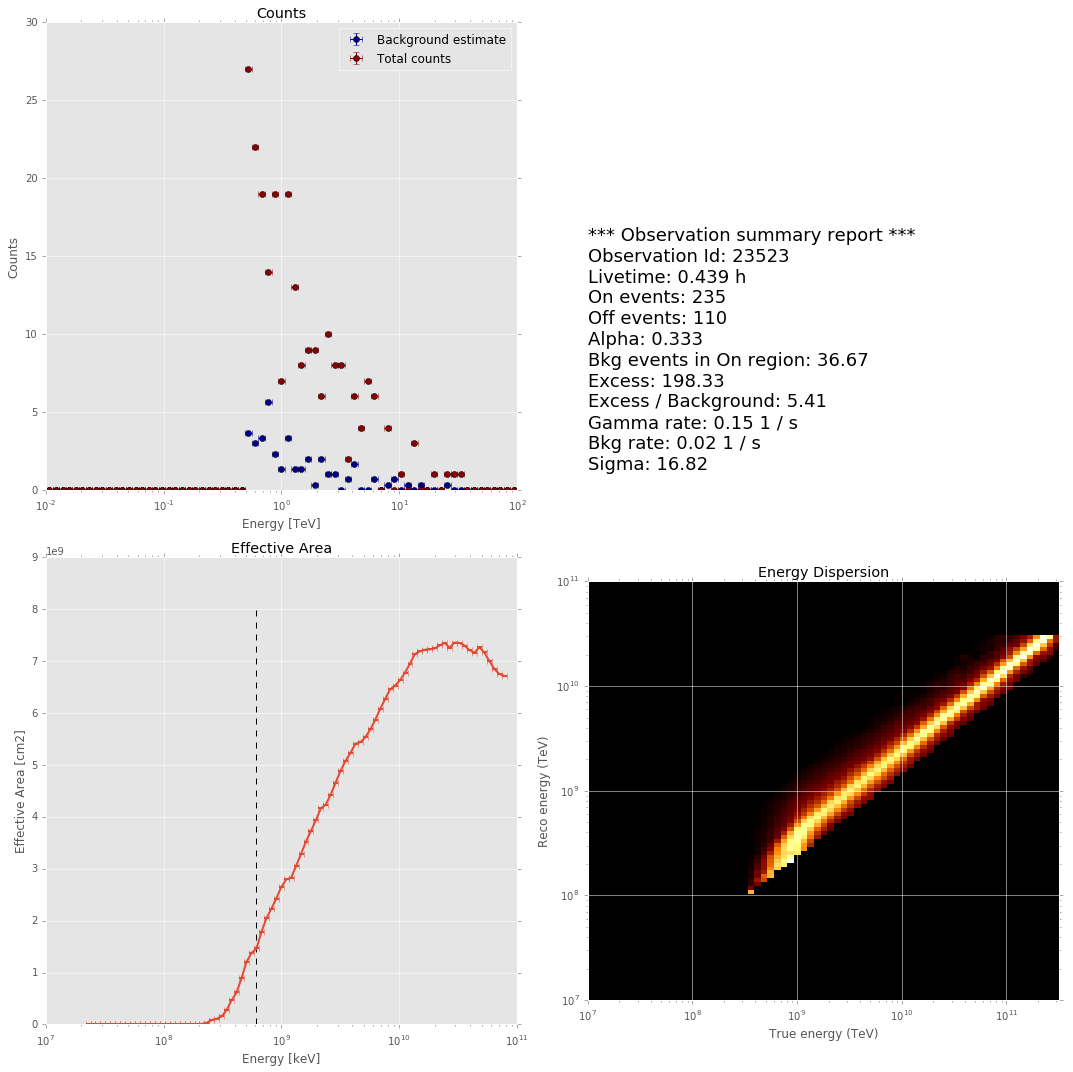

In [7]:
extraction.observations[0].peek()

In [8]:
from gammapy.spectrum import SpectrumFit
fit = SpectrumFit(extraction.observations)
fit.model='PL'
fit.run(outdir = 'crab_analysis')

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


read ARF file ogip_data/arf_obs23523.fits


INFO:sherpa.astro.io:read ARF file ogip_data/arf_obs23523.fits


read RMF file ogip_data/rmf_obs23523.fits


INFO:sherpa.astro.io:read RMF file ogip_data/rmf_obs23523.fits


read background file ogip_data/bkg_obs23523.fits


INFO:sherpa.astro.io:read background file ogip_data/bkg_obs23523.fits


read ARF file ogip_data/arf_obs23559.fits


INFO:sherpa.astro.io:read ARF file ogip_data/arf_obs23559.fits


read RMF file ogip_data/rmf_obs23559.fits


INFO:sherpa.astro.io:read RMF file ogip_data/rmf_obs23559.fits


read background file ogip_data/bkg_obs23559.fits


INFO:sherpa.astro.io:read background file ogip_data/bkg_obs23559.fits


Datasets              = 1, 2
Method                = levmar
Statistic             = wstat
Initial fit statistic = 163.448
Final fit statistic   = 80.5188 at function evaluation 25
Data points           = 78
Degrees of freedom    = 76
Probability [Q-value] = 0.339676
Reduced statistic     = 1.05946
Change in statistic   = 82.9294
   powlaw1d.default.gamma   2.27812     
   powlaw1d.default.ampl   2.25674     


INFO:sherpa.astro.ui.utils:Datasets              = 1, 2
Method                = levmar
Statistic             = wstat
Initial fit statistic = 163.448
Final fit statistic   = 80.5188 at function evaluation 25
Data points           = 78
Degrees of freedom    = 76
Probability [Q-value] = 0.339676
Reduced statistic     = 1.05946
Change in statistic   = 82.9294
   powlaw1d.default.gamma   2.27812     
   powlaw1d.default.ampl   2.25674     


Datasets              = 1, 2
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = wstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   powlaw1d.default.gamma      2.27812   -0.0690464    0.0690464
   powlaw1d.default.ampl      2.25674    -0.166951     0.166951


INFO:sherpa.ui.utils:Datasets              = 1, 2
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = wstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   powlaw1d.default.gamma      2.27812   -0.0690464    0.0690464
   powlaw1d.default.ampl      2.25674    -0.166951     0.166951


In [10]:
print(fit.result[0].fit)

Fit result info 
--------------- 
Model: PowerLaw 
Parameters: 
	 index     : 2.278 +/- 0.069 
	 norm      : (22.567 +/- 1.670) x 1e-12 / (cm2 s TeV)
	 reference : 1000000000.000 +/- 0.000 keV

Statistic: 80.519 (wstat)
Covariance:
 [[ 0.0047674   0.00519099]
 [ 0.00519099  0.02787271]]
Fit Range: [  6.79045408e+08   8.24908677e+10] keV


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1081a22550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1083cb7d90>)

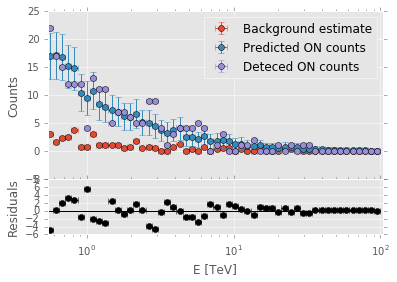

In [14]:
fit.result.plot_fit()